#### Supplemental figures showing the sensitivity of the ML prognostic run evolution to choice of nudging timescale

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import fsspec
import xarray as xr
import numpy as np

from vcm.catalog import catalog
from vcm.fv3.metadata import standardize_fv3_diagnostics

SECONDS_PER_DAY = 86400

timescales = [1, 3, 6, 12]
paths = [
    f"gs://vcm-ml-public/argo/2021-05-18-nudge-to-c3072-prog-timescales-correct-winds/prognostic-rf-{tau}hr-nudging-timescale"
    for tau in timescales
]

   

gs://vcm-ml-public/argo/2021-05-18-nudge-to-c3072-prog-timescales-correct-winds/prognostic-rf-1hr-nudging-timescale
gs://vcm-ml-public/argo/2021-05-18-nudge-to-c3072-prog-timescales-correct-winds/prognostic-rf-3hr-nudging-timescale
gs://vcm-ml-public/argo/2021-05-18-nudge-to-c3072-prog-timescales-correct-winds/prognostic-rf-6hr-nudging-timescale
gs://vcm-ml-public/argo/2021-05-18-nudge-to-c3072-prog-timescales-correct-winds/prognostic-rf-12hr-nudging-timescale


In [ ]:
grid = catalog["grid/c48"].read()
area = grid["area"]

land_sea_mask = catalog["landseamask/c48"].read()["land_sea_mask"]
area_land_mask = area.where(land_sea_mask==1)

In [ ]:
diags = {}
for tau, path in zip(timescales, paths):
    print(path)
    with fsspec.open(f"{path}/diags.nc", "rb") as f:
        diags[tau] = xr.open_dataset(f).load()
        
with fsspec.open("gs://vcm-ml-public/argo/prog-report-2021-05-14-nn-rf-40day/baseline/diags.nc", "rb") as f:
    diags_baseline = xr.open_dataset(f).load()

In [6]:
verif_physics =  standardize_fv3_diagnostics(catalog['40day_c48_gfsphysics_15min_may2020'].to_dask())
verif_physics["total_precip_to_surface"] = verif_physics["PRATEsfc"] * SECONDS_PER_DAY

verif_physics["total_precip_to_surface_spatial_mean_physics_land"] = (
    (verif_physics["total_precip_to_surface"] * area_land_mask).sum(skipna=True, dim=["tile", "x", "y"]) 
    / area_land_mask.sum(skipna=True)
)

<Figure size 432x288 with 0 Axes>

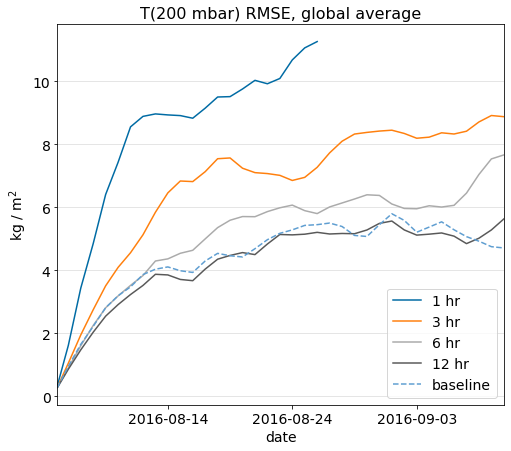

In [10]:
var = "tmp200_rms_global"
fig = plt.figure()

fig=plt.figure(figsize=(8,7))

for tau, ds in diags.items():
    downsample_times = [ds.time.values[0]] + [t for t in ds.time.values if t.hour==0]
    subset_times = list(set(downsample_times).intersection(list(verif_physics.time.values)))
    ds[var].sel(time=subset_times).sortby("time").plot(label=f"{tau} hr")
diags_baseline[var].sel(time=subset_times).sortby("time").plot(label="baseline", linestyle="--")

plt.legend()
plt.xlabel("date", fontsize=14)
plt.ylabel("kg / m$^2$", fontsize=14)

plt.xlim(min(subset_times), max(subset_times))
#plt.ylim(24, 29)

plt.grid(True, axis="y", alpha=0.4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("T(200 mbar) RMSE, global average", fontsize=16)

plt.legend(loc="lower right",  fontsize=14)
plt.savefig("figures/nudging_tau_sensitivity_rmse_t200_time_series.png")

<Figure size 432x288 with 0 Axes>

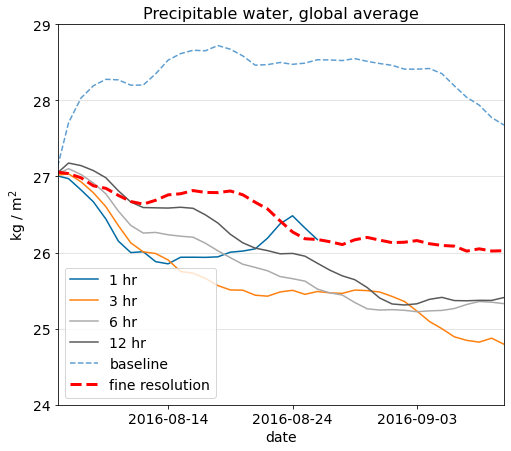

In [11]:
fig = plt.figure()

fig=plt.figure(figsize=(8,7))

for tau, ds in diags.items():
    downsample_times = [ds.time.values[0]] + [t for t in ds.time.values if t.hour==0]
    subset_times = list(set(downsample_times).intersection(list(verif_physics.time.values)))   
    ds['pwat_spatial_mean_dycore_global'].sel(time=subset_times).sortby("time").plot(label=f"{tau} hr")
#verif_precip_land_mean.sel(time=subset_times).sortby("time").plot(linestyle="--", label="fine resolution", linewidth=3, color="red",)
diags_baseline['pwat_spatial_mean_dycore_global'].sel(time=subset_times).sortby("time").plot(label="baseline", linestyle="--")

verif_pw = ds['pwat_spatial_mean_dycore_global'] -  ds['pwat_mean_bias_dycore_global']
verif_pw.sel(time=subset_times).sortby("time").plot(linestyle="--", label="fine resolution", linewidth=3, color="red",)

plt.legend()
plt.xlabel("date", fontsize=14)
plt.ylabel("kg / m$^2$", fontsize=14)

plt.xlim(min(subset_times), max(subset_times))
plt.ylim(24, 29)

plt.grid(True, axis="y", alpha=0.4)
plt.xticks(fontsize=14)
plt.yticks( fontsize=14)
plt.title("Precipitable water, global average", fontsize=16)

plt.legend(loc="lower left",  fontsize=14)
plt.savefig("figures/nudging_tau_sensitivity_pwat_time_series.png")

<Figure size 432x288 with 0 Axes>

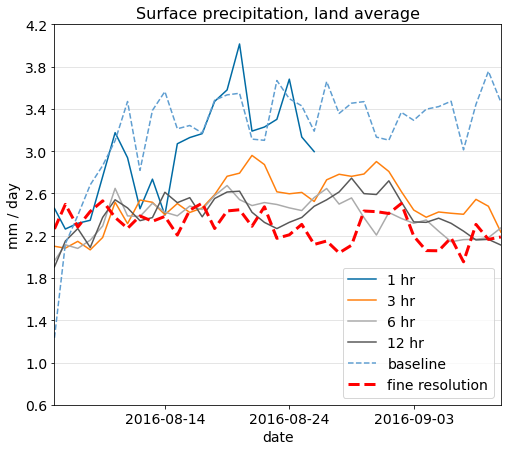

In [13]:
fig = plt.figure()

fig=plt.figure(figsize=(8,7))

for tau, ds in diags.items():
    downsample_times = [ds.time.values[0]] + [t for t in ds.time.values if t.hour==0]
    subset_times = list(set(downsample_times).intersection(list(verif_physics.time.values)))
    ds["total_precip_to_surface_spatial_mean_physics_land"] \
        .sel(time=subset_times) \
        .sortby("time") \
        .plot(label=f"{tau} hr")


diags_baseline["total_precip_to_surface_spatial_mean_physics_land"] \
    .sel(time=subset_times) \
    .sortby("time") \
    .plot(
        label="baseline",
        linestyle="--"
    )
    
verif_physics["total_precip_to_surface_spatial_mean_physics_land"] \
    .sel(time=subset_times).sortby("time") \
    .plot(
        linestyle="--",
        label="fine resolution",
        linewidth=3, 
        color="red",
    )

plt.legend()
plt.xlabel("date", fontsize=14)
plt.ylabel("mm / day", fontsize=14)

plt.xlim(min(subset_times), max(subset_times))
plt.ylim(0.6, 4.2)

plt.grid(True, axis="y", alpha=0.4)
plt.xticks(fontsize=14)

plt.yticks(np.linspace(0.6, 4.2, 10), fontsize=14)
plt.title("Surface precipitation, land average", fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.savefig("figures/nudging_tau_sensitivity_sfc_precip_time_series.png")